# setup and configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle

# --- Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-darkgrid')

# --- Random Seed ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

# --- Model/Metrics ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- ML Models ---
import lightgbm as lgb
import xgboost as xgb

# --- Tuning ---
try:
    import optuna
except ImportError:
    print("Installing Optuna...")
    !pip install optuna -q
    import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Feature Engineering Helpers ---
try:
    from pyzipcode import ZipCodeDatabase
except ImportError:
    print("Installing pyzipcode...")
    !pip install pyzipcode -q
    from pyzipcode import ZipCodeDatabase

print("\n✓ Setup complete. All libraries loaded.")



Installing Optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.8 MB/s eta 0:00:00
Installing pyzipcode...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

✓ Setup complete. All libraries loaded.


# data loading


In [3]:
# --- Helper ---
# This is the state extractor function from Carol's notebook.
# We define it here so it's available for the feature engineering step.
zcdb = ZipCodeDatabase()
def get_state(zip_code):
    """Converts a zip code to a 2-letter state, handling errors."""
    try:
        # Format zip code to 5 digits, handling floats/ints
        zip_code_str = str(int(zip_code)).zfill(5)
        return zcdb[zip_code_str].state
    except:
        return 'Unknown' # Use 'Unknown' for NaNs or invalid zips

print("✓ State feature helper created.")


# --- Load Data ---
from google.colab import files

try:
    # Try loading directly if files are already in the environment
    train_df = pd.read_csv('Training_TriGuard.csv')
    test_df = pd.read_csv('Testing_TriGuard.csv')
    print("✓ Files loaded from local environment.")
except FileNotFoundError:
    print("Please upload Training_TriGuard.csv:")
    uploaded_train = files.upload()
    train_file = list(uploaded_train.keys())[0]
    train_df = pd.read_csv(train_file)

    print("\nPlease upload Testing_TriGuard.csv:")
    uploaded_test = files.upload()
    test_file = list(uploaded_test.keys())[0]
    test_df = pd.read_csv(test_file)
    print("✓ Files uploaded successfully.")

# --- Critical Cleaning ---
# Drop the 2 rows with NaN target variable
initial_train_count = len(train_df)
train_df = train_df.dropna(subset=['subrogation'])
print(f"\nCleaned training data: Removed {initial_train_count - len(train_df)} rows with NaN target.")

# Cast target to int
train_df['subrogation'] = train_df['subrogation'].astype(int)

# --- Review Data ---
print(f"\n✓ Train shape: {train_df.shape}")
print(f"✓ Test shape: {test_df.shape}")
print(f"\nTarget distribution (after cleaning):")
print(train_df['subrogation'].value_counts(normalize=True).to_string())

# Save test IDs for final submission
test_ids = test_df['claim_number'].copy()



✓ State feature helper created.
Please upload Training_TriGuard.csv:


Saving Training_TriGuard.csv to Training_TriGuard.csv

Please upload Testing_TriGuard.csv:


Saving Testing_TriGuard.csv to Testing_TriGuard.csv
✓ Files uploaded successfully.

Cleaned training data: Removed 2 rows with NaN target.

✓ Train shape: (17999, 29)
✓ Test shape: (12000, 28)

Target distribution (after cleaning):
subrogation
0   0.771
1   0.229


# feature engineering


In [7]:
def feature_engineer(df, is_train=True):
    """
    Applies all 160+ features to a train or test dataframe.
    Combines features from both Cecilia's and Carol's notebooks.
    """
    df_fe = df.copy()

    # =======================================================================
    # TEMPORAL FEATURES (Cecilia + Carol)
    # =======================================================================
    df_fe['claim_date'] = pd.to_datetime(df_fe['claim_date'], errors='coerce')
    df_fe['claim_year'] = df_fe['claim_date'].dt.year
    df_fe['claim_month'] = df_fe['claim_date'].dt.month
    df_fe['claim_day'] = df_fe['claim_date'].dt.day
    df_fe['claim_quarter'] = df_fe['claim_date'].dt.quarter
    df_fe['claim_dayofweek'] = df_fe['claim_date'].dt.dayofweek
    df_fe['is_weekend'] = (df_fe['claim_dayofweek'] >= 5).astype(int)
    df_fe['is_monday'] = (df_fe['claim_dayofweek'] == 0).astype(int)
    df_fe['is_friday'] = (df_fe['claim_dayofweek'] == 4).astype(int)
    df_fe['is_q4'] = (df_fe['claim_quarter'] == 4).astype(int)

    # --- NEW (Carol) ---
    season_map = {
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall',
        12: 'Winter', 1: 'Winter', 2: 'Winter'
    }
    df_fe['season'] = df_fe['claim_month'].map(season_map).fillna('Unknown')

    # =======================================================================
    # GEOSPATIAL FEATURE (Carol)
    # =======================================================================
    # --- NEW (Carol) ---
    # Note: get_state function was defined in the previous cell
    df_fe['state'] = df_fe['zip_code'].apply(get_state)

    # =======================================================================
    # DATA CLEANING & LOG TRANSFORMS (Cecilia + Carol)
    # =======================================================================
    df_fe.loc[(df_fe['year_of_born'] < 1900) | (df_fe['year_of_born'] > 2025), 'year_of_born'] = np.nan
    future_mask = df_fe['vehicle_made_year'] > df_fe['claim_year']
    df_fe.loc[future_mask, 'vehicle_made_year'] = np.nan

    # --- NEW (Carol) ---
    # Log transforms to handle skewed numerical data
    df_fe['log_claim_est_payout'] = np.log1p(df_fe['claim_est_payout'])
    df_fe['log_vehicle_mileage'] = np.log1p(df_fe['vehicle_mileage'])
    df_fe['log_vehicle_price'] = np.log1p(df_fe['vehicle_price'])

    # =======================================================================
    # TIER 1: CRITICAL INTERACTION FEATURES (Cecilia)
    # =======================================================================
    df_fe['witness_binary'] = (df_fe['witness_present_ind'] == 'Y').astype(int)
    df_fe['police_binary'] = df_fe['policy_report_filed_ind']
    df_fe['multicar_binary'] = df_fe['accident_type'].isin(['multi_vehicle_clear', 'multi_vehicle_unclear']).astype(int)
    df_fe['highrisk_site_binary'] = df_fe['accident_site'].isin(['Highway/Intersection', 'Local']).astype(int)

    # Use .fillna(0) for safety in case liab_prct is null, though we'll impute later
    df_fe['liab_x_witness'] = df_fe['liab_prct'].fillna(0) * df_fe['witness_binary']
    df_fe['liab_x_police'] = df_fe['liab_prct'].fillna(0) * df_fe['police_binary']
    df_fe['liab_x_multicar'] = df_fe['liab_prct'].fillna(0) * df_fe['multicar_binary']
    df_fe['liab_x_highrisk_site'] = df_fe['liab_prct'].fillna(0) * df_fe['highrisk_site_binary']
    df_fe['liab_x_evidence'] = df_fe['liab_prct'].fillna(0) * (df_fe['witness_binary'] + df_fe['police_binary'])

    df_fe['witness_x_police'] = df_fe['witness_binary'] * df_fe['police_binary']
    df_fe['witness_x_multicar'] = df_fe['witness_binary'] * df_fe['multicar_binary']
    df_fe['police_x_multicar'] = df_fe['police_binary'] * df_fe['multicar_binary']
    df_fe['multicar_x_highrisk'] = df_fe['multicar_binary'] * df_fe['highrisk_site_binary']

    # =======================================================================
    # TIER 2: POLYNOMIAL FEATURES (Cecilia)
    # =======================================================================
    df_fe['liab_prct_squared'] = df_fe['liab_prct'] ** 2
    df_fe['liab_prct_cubed'] = df_fe['liab_prct'] ** 3
    df_fe['liab_prct_sqrt'] = np.sqrt(df_fe['liab_prct'])
    df_fe['liab_prct_log'] = np.log1p(df_fe['liab_prct'])
    df_fe['liab_inverse'] = 100 - df_fe['liab_prct']
    df_fe['liab_inverse_squared'] = (100 - df_fe['liab_prct']) ** 2

    # =======================================================================
    # ACCIDENT TYPE & EVIDENCE FEATURES (Cecilia)
    # =======================================================================
    df_fe['is_multi_vehicle_clear'] = (df_fe['accident_type'] == 'multi_vehicle_clear').astype(int)
    df_fe['is_multi_vehicle_unclear'] = (df_fe['accident_type'] == 'multi_vehicle_unclear').astype(int)
    df_fe['is_single_car'] = (df_fe['accident_type'] == 'single_car').astype(int)
    df_fe['has_recovery_target'] = df_fe['multicar_binary']
    df_fe['recovery_case_clarity'] = 0
    df_fe.loc[df_fe['is_multi_vehicle_clear'] == 1, 'recovery_case_clarity'] = 3
    df_fe.loc[df_fe['is_multi_vehicle_unclear'] == 1, 'recovery_case_clarity'] = 1

    df_fe['witness_present'] = df_fe['witness_binary']
    df_fe['police_report'] = df_fe['police_binary']
    df_fe['evidence_none'] = ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 0)).astype(int)
    df_fe['evidence_weak'] = (((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 0)) |
                           ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 1))).astype(int)
    df_fe['evidence_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1)).astype(int)
    df_fe['evidence_very_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1) &
                                  (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['evidence_score'] = df_fe['witness_present'] + df_fe['police_report']

    # =======================================================================
    # LIABILITY BUCKETS (Cecilia)
    # =======================================================================
    df_fe['liab_under_10'] = (df_fe['liab_prct'] < 10).astype(int)
    df_fe['liab_10_to_15'] = ((df_fe['liab_prct'] >= 10) & (df_fe['liab_prct'] < 15)).astype(int)
    df_fe['liab_15_to_20'] = ((df_fe['liab_prct'] >= 15) & (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['liab_20_to_25'] = ((df_fe['liab_prct'] >= 20) & (df_fe['liab_prct'] < 25)).astype(int)
    df_fe['liab_25_to_30'] = ((df_fe['liab_prct'] >= 25) & (df_fe['liab_prct'] < 30)).astype(int)
    df_fe['liab_30_to_35'] = ((df_fe['liab_prct'] >= 30) & (df_fe['liab_prct'] < 35)).astype(int)
    df_fe['liab_35_to_40'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 40)).astype(int)
    df_fe['liab_40_to_50'] = ((df_fe['liab_prct'] >= 40) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['liab_over_50'] = (df_fe['liab_prct'] >= 50).astype(int)
    df_fe['not_at_fault'] = df_fe['liab_under_10']
    df_fe['minimal_fault'] = (df_fe['liab_prct'] < 25).astype(int)
    df_fe['low_fault'] = (df_fe['liab_prct'] < 35).astype(int)
    df_fe['shared_fault'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['high_fault'] = (df_fe['liab_prct'] >= 50).astype(int)

    # =======================================================================
    # ACCIDENT SITE FEATURES (Cecilia)
    # =======================================================================
    df_fe['high_risk_site'] = df_fe['highrisk_site_binary']
    df_fe['parking_accident'] = (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['unknown_site'] = (df_fe['accident_site'] == 'Unknown').astype(int)
    df_fe['highway_accident'] = (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['local_accident'] = (df_fe['accident_site'] == 'Local').astype(int)

    # =======================================================================
    # DRIVER AGE & EXPERIENCE (Cecilia + Carol)
    # =======================================================================
    df_fe['driver_age'] = df_fe['claim_year'] - df_fe['year_of_born']
    df_fe.loc[(df_fe['driver_age'] < 16) | (df_fe['driver_age'] > 100), 'driver_age'] = np.nan

    df_fe['young_driver'] = ((df_fe['driver_age'] >= 16) & (df_fe['driver_age'] <= 25)).astype(int)
    df_fe['prime_driver'] = ((df_fe['driver_age'] > 25) & (df_fe['driver_age'] <= 45)).astype(int)
    df_fe['middle_age_driver'] = ((df_fe['driver_age'] > 45) & (df_fe['driver_age'] <= 65)).astype(int)
    df_fe['senior_driver'] = (df_fe['driver_age'] > 65).astype(int)

    # Carol's version (handles negatives)
    df_fe['driving_experience'] = (df_fe['driver_age'] - df_fe['age_of_DL']).clip(lower=0)
    df_fe.loc[df_fe['driving_experience'] < 0, 'driving_experience'] = np.nan

    df_fe['novice_driver'] = (df_fe['driving_experience'] < 3).astype(int)
    df_fe['experienced_driver'] = ((df_fe['driving_experience'] >= 3) & (df_fe['driving_experience'] <= 10)).astype(int)
    df_fe['veteran_driver'] = (df_fe['driving_experience'] > 10).astype(int)

    # --- NEW (Carol) ---
    df_fe['experience_x_safety'] = df_fe['driving_experience'] * df_fe['safety_rating']
    df_fe['safety_x_prior_claims'] = df_fe['safety_rating'] / (1 + df_fe['past_num_of_claims'])

    # =======================================================================
    # VEHICLE FEATURES (Cecilia)
    # =======================================================================
    df_fe['vehicle_age'] = df_fe['claim_year'] - df_fe['vehicle_made_year']
    df_fe['new_vehicle'] = (df_fe['vehicle_age'] <= 2).astype(int)
    df_fe['mid_age_vehicle'] = ((df_fe['vehicle_age'] > 2) & (df_fe['vehicle_age'] <= 7)).astype(int)
    df_fe['old_vehicle'] = (df_fe['vehicle_age'] > 10).astype(int)

    df_fe['luxury_vehicle'] = (df_fe['vehicle_price'] > 50000).astype(int)
    df_fe['mid_price_vehicle'] = ((df_fe['vehicle_price'] >= 20000) & (df_fe['vehicle_price'] <= 50000)).astype(int)
    df_fe['economy_vehicle'] = (df_fe['vehicle_price'] < 20000).astype(int)

    df_fe['heavy_vehicle'] = (df_fe['vehicle_weight'] > 30000).astype(int)
    df_fe['light_vehicle'] = (df_fe['vehicle_weight'] < 15000).astype(int)

    df_fe['is_large_vehicle'] = (df_fe['vehicle_category'] == 'Large').astype(int)
    df_fe['is_compact_vehicle'] = (df_fe['vehicle_category'] == 'Compact').astype(int)

    # =======================================================================
    # CLAIM CHARACTERISTICS (Cecilia)
    # =======================================================================
    df_fe['high_mileage'] = (df_fe['vehicle_mileage'] > 100000).astype(int)
    df_fe['low_mileage'] = (df_fe['vehicle_mileage'] < 50000).astype(int)
    df_fe['very_high_mileage'] = (df_fe['vehicle_mileage'] > 150000).astype(int)

    df_fe['frequent_claimer'] = (df_fe['past_num_of_claims'] > 5).astype(int)
    df_fe['moderate_claimer'] = ((df_fe['past_num_of_claims'] >= 1) & (df_fe['past_num_of_claims'] <= 5)).astype(int)
    df_fe['first_time_claimer'] = (df_fe['past_num_of_claims'] == 0).astype(int)
    df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)

    df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
    df_fe['medium_payout'] = ((df_fe['claim_est_payout'] >= 2000) & (df_fe['claim_est_payout'] <= 5000)).astype(int)
    df_fe['small_payout'] = (df_fe['claim_est_payout'] < 2000).astype(int)
    df_fe['very_large_payout'] = (df_fe['claim_est_payout'] > 8000).astype(int)

    # =======================================================================
    # TIER 4: RATIO FEATURES (Cecilia + Carol)
    # =======================================================================
    df_fe['payout_to_price_ratio'] = df_fe['claim_est_payout'] / (df_fe['vehicle_price'] + 1)
    df_fe['severe_damage'] = (df_fe['payout_to_price_ratio'] > 0.3).astype(int)
    df_fe['moderate_damage'] = ((df_fe['payout_to_price_ratio'] >= 0.1) & (df_fe['payout_to_price_ratio'] <= 0.3)).astype(int)
    df_fe['minor_damage'] = (df_fe['payout_to_price_ratio'] < 0.1).astype(int)

    # --- FIX (from Carol's name) ---
    # We will use your original name 'income_to_price_ratio' for consistency
    df_fe['income_to_price_ratio'] = df_fe['annual_income'] / (df_fe['vehicle_price'] + 1)
    df_fe['can_afford_vehicle'] = (df_fe['income_to_price_ratio'] >= 0.5).astype(int)
    df_fe['expensive_for_income'] = (df_fe['income_to_price_ratio'] < 0.3).astype(int)

    df_fe['mileage_per_year'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_age'] + 1)
    df_fe['high_annual_mileage'] = (df_fe['mileage_per_year'] > 15000).astype(int)

    df_fe['claims_per_year_driving'] = df_fe['past_num_of_claims'] / (df_fe['driving_experience'] + 1)
    df_fe['claim_frequency_high'] = (df_fe['claims_per_year_driving'] > 0.5).astype(int)

    df_fe['safety_to_liability'] = df_fe['safety_rating'] / (df_fe['liab_prct'] + 1)
    df_fe['payout_to_income'] = df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)

    # =======================================================================
    # POLICYHOLDER CHARACTERISTICS (Cecilia)
    # =======================================================================
    df_fe['high_income'] = (df_fe['annual_income'] > 70000).astype(int)
    df_fe['mid_income'] = ((df_fe['annual_income'] >= 40000) & (df_fe['annual_income'] <= 70000)).astype(int)
    df_fe['low_income'] = (df_fe['annual_income'] < 40000).astype(int)
    df_fe['very_high_income'] = (df_fe['annual_income'] > 100000).astype(int)

    df_fe['high_safety_rating'] = (df_fe['safety_rating'] > 80).astype(int)
    df_fe['low_safety_rating'] = (df_fe['safety_rating'] < 60).astype(int)
    df_fe['very_high_safety'] = (df_fe['safety_rating'] > 90).astype(int)

    df_fe['contact_available'] = df_fe['email_or_tel_available']
    df_fe['has_education'] = df_fe['high_education_ind']
    df_fe['recent_move'] = df_fe['address_change_ind']
    df_fe['home_owner'] = (df_fe['living_status'] == 'Own').astype(int)
    df_fe['renter'] = (df_fe['living_status'] == 'Rent').astype(int)
    df_fe['female'] = (df_fe['gender'] == 'F').astype(int)

    # =======================================================================
    # CHANNEL FEATURES (Cecilia)
    # =======================================================================
    df_fe['via_broker'] = (df_fe['channel'] == 'Broker').astype(int)
    df_fe['via_online'] = (df_fe['channel'] == 'Online').astype(int)
    df_fe['via_phone'] = (df_fe['channel'] == 'Phone').astype(int)
    df_fe['in_network_repair'] = (df_fe['in_network_bodyshop'] == 'yes').astype(int)

    # =======================================================================
    # TIER 5: COMPOSITE SCORES (Cecilia)
    # =======================================================================
    liability_score = np.sqrt((100 - df_fe['liab_prct']) / 100.0)
    evidence_score = (df_fe['evidence_none'] * 0.0 + df_fe['evidence_weak'] * 0.4 +
                      df_fe['evidence_strong'] * 0.7 + df_fe['evidence_very_strong'] * 1.0)
    clarity_score = df_fe['recovery_case_clarity'] / 3.0
    site_score = df_fe['high_risk_site'] * 0.7 + (1 - df_fe['unknown_site']) * 0.3

    df_fe['recovery_feasibility_score'] = (0.35 * liability_score + 0.30 * df_fe['has_recovery_target'] +
                                         0.20 * evidence_score + 0.10 * clarity_score + 0.05 * site_score)

    # =======================================================================
    # TIER 6: DOMAIN LOGIC FLAGS (Cecilia)
    # =======================================================================
    df_fe['perfect_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['witness_present'] == 1) &
                          (df_fe['police_report'] == 1) & (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['strong_case'] = ((df_fe['liab_prct'] < 25) & (df_fe['evidence_strong'] == 1) &
                         (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['good_case'] = ((df_fe['liab_prct'] < 35) & (df_fe['evidence_score'] >= 1) &
                       (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['weak_case'] = ((df_fe['liab_prct'] > 40) | (df_fe['is_single_car'] == 1) |
                       (df_fe['evidence_none'] == 1)).astype(int)
    df_fe['no_case'] = ((df_fe['liab_prct'] > 60) | ((df_fe['is_single_car'] == 1) & (df_fe['evidence_none'] == 1))).astype(int)
    df_fe['high_value_opportunity'] = ((df_fe['claim_est_payout'] > 3000) & (df_fe['liab_prct'] < 30) &
                                     (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['slam_dunk_case'] = ((df_fe['liab_prct'] < 10) & (df_fe['witness_present'] == 1) &
                            (df_fe['police_report'] == 1) & (df_fe['multicar_binary'] == 1) &
                            (df_fe['high_risk_site'] == 1)).astype(int)

    # =======================================================================
    # TARGET ENCODING (Cecilia)
    # =======================================================================
    # Only apply this to the training data. We'll map to the test set later.
    if is_train:
        cat_for_encoding = ['accident_site', 'accident_type', 'channel',
                            'vehicle_category', 'vehicle_color', 'living_status',
                            'claim_day_of_week', 'gender', 'in_network_bodyshop',
                            'state', 'season'] # Added 'state' and 'season'

        global_mean = df_fe['subrogation'].mean()

        for col in cat_for_encoding:
            # Calculate mean subrogation rate per category
            target_mean = df_fe.groupby(col)['subrogation'].mean()

            # Apply smoothing
            category_counts = df_fe.groupby(col).size()
            smoothing = 10  # Smoothing factor
            smoothed_mean = (target_mean * category_counts + global_mean * smoothing) / (category_counts + smoothing)

            df_fe[f'{col}_target_enc'] = df_fe[col].map(smoothed_mean)

    return df_fe

# --- Run Feature Engineering ---
print("="*80)
print("Starting Combined Feature Engineering (Cecilia + Carol)...")

print("\nProcessing training data...")
train_fe = feature_engineer(train_df, is_train=True)
print("Processing test data...")
test_fe = feature_engineer(test_df, is_train=False)

# --- Apply Target Encoding to Test Set ---
# Now, map the encodings learned from the *training* data onto the *test* data
print("\nApplying learned target encodings to test set...")
cat_for_encoding = ['accident_site', 'accident_type', 'channel',
                    'vehicle_category', 'vehicle_color', 'living_status',
                    'claim_day_of_week', 'gender', 'in_network_bodyshop',
                    'state', 'season']
global_mean = train_df['subrogation'].mean()

for col in cat_for_encoding:
    # Get the learned mapping from the training set
    target_mean_map = train_fe.groupby(col)[f'{col}_target_enc'].mean()

    # Apply to test set, fill any new/unseen categories with the global mean
    test_fe[f'{col}_target_enc'] = test_fe[col].map(target_mean_map).fillna(global_mean)


print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE")
print(f"✓ New train shape: {train_fe.shape}")
print(f"✓ New test shape: {test_fe.shape}")
print(f"✓ Total features created: {len(train_fe.columns) - len(train_df.columns)} new features")



Starting Combined Feature Engineering (Cecilia + Carol)...

Processing training data...
Processing test data...

Applying learned target encodings to test set...

FEATURE ENGINEERING COMPLETE
✓ New train shape: (17999, 175)
✓ New test shape: (12000, 174)
✓ Total features created: 146 new features


# pre-modeling


In [8]:
print("="*80)
print("Starting Pre-Modeling Data Prep...")

# Define the columns to drop from the feature sets
# These are identifiers, the target, or raw columns we've already transformed
DROP_COLS = ['subrogation', 'claim_number', 'claim_date', 'year_of_born',
             'witness_present_ind', 'policy_report_filed_ind']

# Get the target variable
y_all = train_fe['subrogation'].copy()

# Get the feature columns (all columns except the drop list)
feature_cols = [col for col in train_fe.columns if col not in DROP_COLS]

# Create the full feature dataframes
# We will align columns to ensure train and test have the exact same features
X_all = train_fe[feature_cols].copy()
X_test_all = test_fe[feature_cols].copy()

# --- 1. Label Encode Categorical Features ---
# LightGBM can handle label-encoded categoricals directly
cat_cols = X_all.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nFound {len(cat_cols)} categorical features to Label Encode:")
print(cat_cols)

for col in cat_cols:
    le = LabelEncoder()

    # Combine train and test for a full fit to capture all possible categories
    all_values = pd.concat([X_all[col].astype(str), X_test_all[col].astype(str)]).unique()
    le.fit(all_values)

    # Transform both train and test
    X_all[col] = le.transform(X_all[col].astype(str))
    X_test_all[col] = le.transform(X_test_all[col].astype(str))

print("\n✓ Categorical features encoded.")

# --- 2. Impute Missing Values (NaN) ---
# Fill any NaNs created during feature engineering (e.g., from age cleaning or ratios)
# Using the median is robust to outliers
print("\nImputing NaN values with the median from the training data...")
X_all_median = X_all.median()
X_all = X_all.fillna(X_all_median)
X_test_all = X_test_all.fillna(X_all_median)

print("✓ NaN values imputed.")

# --- 3. Calculate scale_pos_weight for Imbalance ---
scale_pos_weight = (y_all == 0).sum() / (y_all == 1).sum()

print("\n" + "="*80)
print("PRE-MODELING COMPLETE")
print(f"✓ X_all shape: {X_all.shape}")
print(f"✓ y_all shape: {y_all.shape}")
print(f"✓ X_test_all shape: {X_test_all.shape}")
print(f"✓ scale_pos_weight (for F1 score): {scale_pos_weight:.4f}")



Starting Pre-Modeling Data Prep...

Found 11 categorical features to Label Encode:
['gender', 'living_status', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color', 'accident_type', 'in_network_bodyshop', 'season', 'state']

✓ Categorical features encoded.

Imputing NaN values with the median from the training data...
✓ NaN values imputed.

PRE-MODELING COMPLETE
✓ X_all shape: (17999, 169)
✓ y_all shape: (17999,)
✓ X_test_all shape: (12000, 169)
✓ scale_pos_weight (for F1 score): 3.3740


# training lightGBM model



In [11]:
print("="*80)
print("Starting Optuna Hyperparameter Tuning for LightGBM...")

# --- 1. Split Data for Tuning ---
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_all
)

print(f"\nData Split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")

# --- 2. Identify Categorical Features for LGBM ---
categorical_features = cat_cols + [
    'claim_year', 'claim_month', 'claim_day', 'claim_quarter', 'claim_dayofweek',
    'is_weekend', 'is_monday', 'is_friday', 'is_q4', 'witness_binary',
    'police_binary', 'multicar_binary', 'highrisk_site_binary',
    'is_multi_vehicle_clear', 'is_multi_vehicle_unclear', 'is_single_car',
    'has_recovery_target', 'liab_under_10', 'liab_10_to_15', 'liab_15_to_20',
    'liab_20_to_25', 'liab_25_to_30', 'liab_30_to_35', 'liab_35_to_40',
    'liab_40_to_50', 'liab_over_50', 'not_at_fault', 'minimal_fault',
    'low_fault', 'shared_fault', 'high_fault', 'witness_present', 'police_report',
    'evidence_none', 'evidence_weak', 'evidence_strong', 'evidence_very_strong',
    'high_risk_site', 'parking_accident', 'unknown_site', 'highway_accident',
    'local_accident', 'young_driver', 'prime_driver', 'middle_age_driver',
    'senior_driver', 'novice_driver', 'experienced_driver', 'veteran_driver',
    'new_vehicle', 'mid_age_vehicle', 'old_vehicle', 'luxury_vehicle',
    'mid_price_vehicle', 'economy_vehicle', 'heavy_vehicle', 'light_vehicle',
    'is_large_vehicle', 'is_compact_vehicle', 'high_mileage', 'low_mileage',
    'very_high_mileage', 'frequent_claimer', 'moderate_claimer', 'first_time_claimer',
    'very_frequent_claimer', 'large_payout', 'medium_payout', 'small_payout',
    'very_large_payout', 'severe_damage', 'moderate_damage', 'minor_damage',
    'can_afford_vehicle', 'expensive_for_income', 'high_annual_mileage',
    'claim_frequency_high', 'high_income', 'mid_income', 'low_income',
    'very_high_income', 'high_safety_rating', 'low_safety_rating',
    'very_high_safety', 'contact_available', 'has_education', 'recent_move',
    'home_owner', 'renter', 'female', 'via_broker', 'via_online', 'via_phone',
    'in_network_repair', 'perfect_case', 'strong_case', 'good_case',
    'weak_case', 'no_case', 'high_value_opportunity', 'slam_dunk_case'
]

print(f"\nIdentified {len(categorical_features)} features as 'categorical' for LGBM.")

# --- 3. Define Optuna Objective Function ---
def objective(trial):
    params = {
        'objective': 'binary',
        # 'metric': 'f1',  <-- REMOVED from params dict
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight, # CRITICAL for F1
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='f1', # <-- ADDED back here
              callbacks=[lgb.early_stopping(100, verbose=False)],
              categorical_feature=categorical_features
             )

    # We use the 'best_score_' from the model, which is the F1 on the validation set
    # that early stopping found. This is more stable than re-calculating with model.predict()
    # which would use the default 0.5 threshold.
    best_f1 = model.best_score_['valid_0']['f1']
    return best_f1

# --- 4. Run the Study ---
print("\nRunning Optuna optimization (50 trials)...")
print("This may take 5-10 minutes. Go get a coffee! ☕")

study = optuna.create_study(direction='maximize', study_name='lgbm_f1_optimization_v3')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*80)
print("OPTUNA TUNING COMPLETE")
print(f"✓ Best F1 Score: {study.best_value:.6f}")
print("\n✓ Best Parameters:")
print(study.best_params)

# Save the best parameters for the next step
best_params_lgbm = study.best_params
best_params_lgbm['scale_pos_weight'] = scale_pos_weight
best_params_lgbm['random_state'] = RANDOM_STATE
best_params_lgbm['n_jobs'] = -1
best_params_lgbm['verbose'] = -1



Starting Optuna Hyperparameter Tuning for LightGBM...

Data Split:
X_train shape: (12599, 169)
X_val shape:   (5400, 169)

Identified 112 features as 'categorical' for LGBM.

Running Optuna optimization (50 trials)...
This may take 5-10 minutes. Go get a coffee! ☕


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-11-05 17:55:03,918] Trial 0 failed with parameters: {'n_estimators': 1699, 'learning_rate': 0.06393359128091708, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.7580555096733963, 'colsample_bytree': 0.6125166999365504, 'reg_alpha': 0.4752770268618415, 'reg_lambda': 0.018846158056942452} because of the following error: KeyError('f1').
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-805405381.py", line 80, in objective
    best_f1 = model.best_score_['valid_0']['f1']
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
KeyError: 'f1'
[W 2025-11-05 17:55:03,920] Trial 0 failed with value None.


KeyError: 'f1'

# training models on all features

In [ ]:
# ============================================================================
# SECTION 6: MODELS ON ALL FEATURES (NO SELECTION)
# ============================================================================

print("="*80)
print("TRAINING MODELS ON ALL 151 FEATURES")
print("="*80)

# Use same 90/10 split
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_raw, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train_all.shape}, Validation: {X_val_all.shape}")

models_all = {}
val_predictions_all = {}
val_probas_all = {}

# ============================================================================
# MODEL 1: LightGBM on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: LightGBM (All 151 Features)")
print("="*80)

lgb_all = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_all.fit(X_train_all, y_train_all)
models_all['lgb'] = lgb_all

val_probas_all['lgb'] = lgb_all.predict_proba(X_val_all)[:, 1]
val_predictions_all['lgb'] = lgb_all.predict(X_val_all)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['lgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['lgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['lgb'])}")

# ============================================================================
# MODEL 2: XGBoost on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBoost (All 151 Features)")
print("="*80)

xgb_all = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_all.fit(X_train_all, y_train_all)
models_all['xgb'] = xgb_all

val_probas_all['xgb'] = xgb_all.predict_proba(X_val_all)[:, 1]
val_predictions_all['xgb'] = xgb_all.predict(X_val_all)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['xgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['xgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['xgb'])}")

# ============================================================================
# MODEL 3: Logistic Regression on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: Logistic Regression (All 151 Features, Scaled)")
print("="*80)

scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_val_all_scaled = scaler_all.transform(X_val_all)

lr_all = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='liblinear'
)

lr_all.fit(X_train_all_scaled, y_train_all)
models_all['lr'] = lr_all

val_probas_all['lr'] = lr_all.predict_proba(X_val_all_scaled)[:, 1]
val_predictions_all['lr'] = lr_all.predict(X_val_all_scaled)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['lr']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['lr']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['lr'])}")

# ============================================================================
# COMPARISON: 70 Features vs 151 Features
# ============================================================================

print("\n" + "="*80)
print("COMPARISON: 70 SELECTED vs 151 ALL FEATURES")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['LightGBM (70)', 'XGBoost (70)', 'LogReg (70)',
              'LightGBM (151)', 'XGBoost (151)', 'LogReg (151)'],
    'F1_Score': [
        f1_score(y_val, val_predictions['lgb']),
        f1_score(y_val, val_predictions['xgb']),
        f1_score(y_val, val_predictions['lr']),
        f1_score(y_val_all, val_predictions_all['lgb']),
        f1_score(y_val_all, val_predictions_all['xgb']),
        f1_score(y_val_all, val_predictions_all['lr'])
    ],
    'ROC_AUC': [
        roc_auc_score(y_val, val_probas['lgb']),
        roc_auc_score(y_val, val_probas['xgb']),
        roc_auc_score(y_val, val_probas['lr']),
        roc_auc_score(y_val_all, val_probas_all['lgb']),
        roc_auc_score(y_val_all, val_probas_all['xgb']),
        roc_auc_score(y_val_all, val_probas_all['lr'])
    ]
})

print(comparison.sort_values('F1_Score', ascending=False))

print(f"\n🏆 BEST OVERALL: {comparison.loc[comparison['F1_Score'].idxmax(), 'Model']}")
print(f"🏆 Best F1: {comparison['F1_Score'].max():.4f}")

TRAINING MODELS ON ALL 151 FEATURES

Train: (16199, 151), Validation: (1800, 151)

MODEL 1: LightGBM (All 151 Features)
F1 Score: 0.5656
ROC AUC: 0.8185

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      1388
         1.0       0.53      0.61      0.57       412

    accuracy                           0.79      1800
   macro avg       0.70      0.72      0.71      1800
weighted avg       0.80      0.79      0.79      1800


MODEL 2: XGBoost (All 151 Features)
F1 Score: 0.5610
ROC AUC: 0.8225

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      1388
         1.0       0.56      0.56      0.56       412

    accuracy                           0.80      1800
   macro avg       0.72      0.72      0.72      1800
weighted avg       0.80      0.80      0.80      1800


MODEL 3: Logistic Regression (All 151 Features, Scaled)
F1 Score: 0.5750
R

# all feature, 0.7/0.3 split


In [ ]:
# ============================================================================
# SECTION 7: MODELS WITH 70/30 SPLIT (RELIABLE VALIDATION)
# ============================================================================

print("="*80)
print("TRAINING WITH 70/30 SPLIT FOR RELIABLE VALIDATION")
print("="*80)

# 70/30 split
X_train_70, X_val_30, y_train_70, y_val_30 = train_test_split(
    X_raw, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train_70.shape}, Validation: {X_val_30.shape}")
print(f"Train target: {y_train_70.value_counts().to_dict()}")
print(f"Val target: {y_val_30.value_counts().to_dict()}")

models_70 = {}
val_predictions_70 = {}
val_probas_70 = {}

# ============================================================================
# MODEL 1: LightGBM
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: LightGBM (70/30 split, 151 features)")
print("="*80)

lgb_70 = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_70.fit(X_train_70, y_train_70)
models_70['lgb'] = lgb_70

val_probas_70['lgb'] = lgb_70.predict_proba(X_val_30)[:, 1]
val_predictions_70['lgb'] = lgb_70.predict(X_val_30)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['lgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['lgb']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['lgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['lgb'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['lgb'])}")

# ============================================================================
# MODEL 2: XGBoost
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBoost (70/30 split, 151 features)")
print("="*80)

xgb_70 = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_70.fit(X_train_70, y_train_70)
models_70['xgb'] = xgb_70

val_probas_70['xgb'] = xgb_70.predict_proba(X_val_30)[:, 1]
val_predictions_70['xgb'] = xgb_70.predict(X_val_30)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['xgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['xgb']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['xgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['xgb'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['xgb'])}")

# ============================================================================
# MODEL 3: Logistic Regression
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: Logistic Regression (70/30 split, 151 features, scaled)")
print("="*80)

scaler_70 = StandardScaler()
X_train_70_scaled = scaler_70.fit_transform(X_train_70)
X_val_30_scaled = scaler_70.transform(X_val_30)

lr_70 = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='liblinear'
)

lr_70.fit(X_train_70_scaled, y_train_70)
models_70['lr'] = lr_70

val_probas_70['lr'] = lr_70.predict_proba(X_val_30_scaled)[:, 1]
val_predictions_70['lr'] = lr_70.predict(X_val_30_scaled)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['lr']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['lr']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['lr']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['lr'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['lr'])}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: 70/30 SPLIT RESULTS")
print("="*80)

summary = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Logistic Regression'],
    'F1_Score': [
        f1_score(y_val_30, val_predictions_70['lgb']),
        f1_score(y_val_30, val_predictions_70['xgb']),
        f1_score(y_val_30, val_predictions_70['lr'])
    ],
    'ROC_AUC': [
        roc_auc_score(y_val_30, val_probas_70['lgb']),
        roc_auc_score(y_val_30, val_probas_70['xgb']),
        roc_auc_score(y_val_30, val_probas_70['lr'])
    ],
    'PR_AUC': [
        average_precision_score(y_val_30, val_probas_70['lgb']),
        average_precision_score(y_val_30, val_probas_70['xgb']),
        average_precision_score(y_val_30, val_probas_70['lr'])
    ]
})

print(summary.sort_values('F1_Score', ascending=False))

print(f"\n🏆 Best Model: {summary.loc[summary['F1_Score'].idxmax(), 'Model']}")
print(f"🏆 Best F1: {summary['F1_Score'].max():.4f}")
print(f"\n📊 Validation size: {X_val_30.shape[0]} samples (30%)")
print(f"📊 This is a MORE RELIABLE estimate than 10% validation")

TRAINING WITH 70/30 SPLIT FOR RELIABLE VALIDATION

Train: (12599, 151), Validation: (5400, 151)
Train target: {0.0: 9719, 1.0: 2880}
Val target: {0.0: 4165, 1.0: 1235}

MODEL 1: LightGBM (70/30 split, 151 features)
F1 Score: 0.5456
ROC AUC: 0.8120
PR AUC: 0.5483

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.86      4165
         1.0       0.52      0.58      0.55      1235

    accuracy                           0.78      5400
   macro avg       0.69      0.71      0.70      5400
weighted avg       0.79      0.78      0.78      5400

Confusion Matrix:
[[3502  663]
 [ 523  712]]

MODEL 2: XGBoost (70/30 split, 151 features)
F1 Score: 0.5335
ROC AUC: 0.8137
PR AUC: 0.5500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      4165
         1.0       0.53      0.54      0.53      1235

    accuracy                           0.78      5400
   ma

# section split ------

# working on lightgbm

In [ ]:
# ============================================================================
# STEP 1: TARGET ENCODING FOR LIGHTGBM
# ============================================================================

print("="*80)
print("STEP 1: ADDING TARGET ENCODING")
print("="*80)

# Identify categorical features
cat_features_for_encoding = ['accident_site', 'accident_type', 'channel',
                              'vehicle_category', 'vehicle_color', 'living_status',
                              'claim_day_of_week', 'gender', 'in_network_bodyshop']

# Create copy of data
train_fe_v2 = train_fe.copy()
test_fe_v2 = test_fe.copy()

# Clean train
train_fe_v2_clean = train_fe_v2.dropna(subset=['subrogation'])

print(f"Creating target encodings for {len(cat_features_for_encoding)} categorical features...")

# Calculate target encoding (mean subrogation rate per category)
for col in cat_features_for_encoding:
    # Calculate mean subrogation rate per category from training data
    target_mean = train_fe_v2_clean.groupby(col)['subrogation'].mean()
    global_mean = train_fe_v2_clean['subrogation'].mean()

    # Apply to train (with smoothing to avoid overfitting)
    category_counts = train_fe_v2_clean.groupby(col).size()
    smoothing = 10  # smoothing factor
    smoothed_mean = (target_mean * category_counts + global_mean * smoothing) / (category_counts + smoothing)

    train_fe_v2_clean[f'{col}_target_enc'] = train_fe_v2_clean[col].map(smoothed_mean)

    # Apply to test (use training stats)
    test_fe_v2[f'{col}_target_enc'] = test_fe_v2[col].map(smoothed_mean).fillna(global_mean)

    print(f"  ✓ {col}: {len(target_mean)} categories encoded")

print(f"\n✓ Target encoding complete!")

# Rebuild feature matrix
drop_cols = ['subrogation', 'claim_number', 'claim_date', 'year_of_born',
             'witness_present_ind', 'policy_report_filed_ind']

feature_cols_v2 = [col for col in train_fe_v2_clean.columns if col not in drop_cols]

X_v2 = train_fe_v2_clean[feature_cols_v2].copy()
y_v2 = train_fe_v2_clean['subrogation'].copy()
X_test_v2 = test_fe_v2[feature_cols_v2].copy()

# Encode remaining categoricals
cat_cols_v2 = X_v2.select_dtypes(include='object').columns.tolist()
print(f"\nEncoding {len(cat_cols_v2)} remaining categorical features...")

for col in cat_cols_v2:
    le = LabelEncoder()
    X_v2[col] = le.fit_transform(X_v2[col].astype(str))
    X_test_v2[col] = le.transform(X_test_v2[col].astype(str))

# Fill NaN
X_v2 = X_v2.fillna(X_v2.median())
X_test_v2 = X_test_v2.fillna(X_test_v2.median())

print(f"\n✓ New feature count: {X_v2.shape[1]} (was 151)")

# Split for validation
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(
    X_v2, y_v2, test_size=0.30, random_state=RANDOM_STATE, stratify=y_v2
)

print(f"✓ Train: {X_train_v2.shape}, Val: {X_val_v2.shape}")

# ============================================================================
# TEST: LightGBM with Target Encoding
# ============================================================================

print("\n" + "="*80)
print("TESTING: LightGBM with Target Encoding")
print("="*80)

lgb_v2 = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_v2.fit(X_train_v2, y_train_v2)
y_val_pred_v2 = lgb_v2.predict(X_val_v2)
y_val_proba_v2 = lgb_v2.predict_proba(X_val_v2)[:, 1]

print(f"\nF1 Score: {f1_score(y_val_v2, y_val_pred_v2):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_v2, y_val_proba_v2):.4f}")
print(f"PR AUC: {average_precision_score(y_val_v2, y_val_proba_v2):.4f}")

print(f"\nClassification Report:\n{classification_report(y_val_v2, y_val_pred_v2)}")

# Compare to baseline
print(f"\n{'='*80}")
print(f"COMPARISON")
print(f"{'='*80}")
print(f"Baseline LightGBM (151 features):     F1 = 0.5456")
print(f"LightGBM + Target Encoding:           F1 = {f1_score(y_val_v2, y_val_pred_v2):.4f}")
print(f"Improvement:                           +{f1_score(y_val_v2, y_val_pred_v2) - 0.5456:.4f}")

if f1_score(y_val_v2, y_val_pred_v2) > 0.5456:
    print("\n✅ IMPROVEMENT! Target encoding helps.")
else:
    print("\n❌ No improvement. May need different approach.")

STEP 1: ADDING TARGET ENCODING
Creating target encodings for 9 categorical features...
  ✓ accident_site: 4 categories encoded
  ✓ accident_type: 3 categories encoded
  ✓ channel: 3 categories encoded
  ✓ vehicle_category: 3 categories encoded
  ✓ vehicle_color: 7 categories encoded
  ✓ living_status: 2 categories encoded
  ✓ claim_day_of_week: 7 categories encoded
  ✓ gender: 2 categories encoded
  ✓ in_network_bodyshop: 2 categories encoded

✓ Target encoding complete!

Encoding 9 remaining categorical features...

✓ New feature count: 160 (was 151)
✓ Train: (12599, 160), Val: (5400, 160)

TESTING: LightGBM with Target Encoding

F1 Score: 0.5508
ROC AUC: 0.8110
PR AUC: 0.5425

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      4165
         1.0       0.52      0.59      0.55      1235

    accuracy                           0.78      5400
   macro avg       0.70      0.71      0.70      5400
weighted avg     

STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION
Installing Optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.8 MB/s eta 0:00:00
✓ Optuna installed

Running Optuna optimization (50 trials, ~5-10 minutes)...
This will test 50 different parameter combinations...



  0%|          | 0/50 [00:00<?, ?it/s]


OPTIMIZATION COMPLETE

🏆 Best F1 Score: 0.5706
🏆 Improvement over baseline: +0.0250
🏆 Improvement over target encoding: +0.0198

📊 Best Parameters:
  n_estimators: 864
  learning_rate: 0.01180364122878554
  num_leaves: 77
  max_depth: 5
  min_child_samples: 24
  subsample: 0.6440543874528366
  colsample_bytree: 0.784340210736604
  reg_alpha: 0.1475355558711881
  reg_lambda: 0.13377640991084788

TRAINING FINAL MODEL WITH BEST PARAMETERS

Tuned LightGBM Performance:
F1 Score: 0.5706
ROC AUC: 0.8217
PR AUC: 0.5709

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      4165
         1.0       0.47      0.73      0.57      1235

    accuracy                           0.75      5400
   macro avg       0.69      0.74      0.70      5400
weighted avg       0.80      0.75      0.76      5400


Confusion Matrix:
[[3133 1032]
 [ 330  905]]

PROGRESS SUMMARY
Baseline LightGBM:           0.5456
+ Target Encoding:           0.

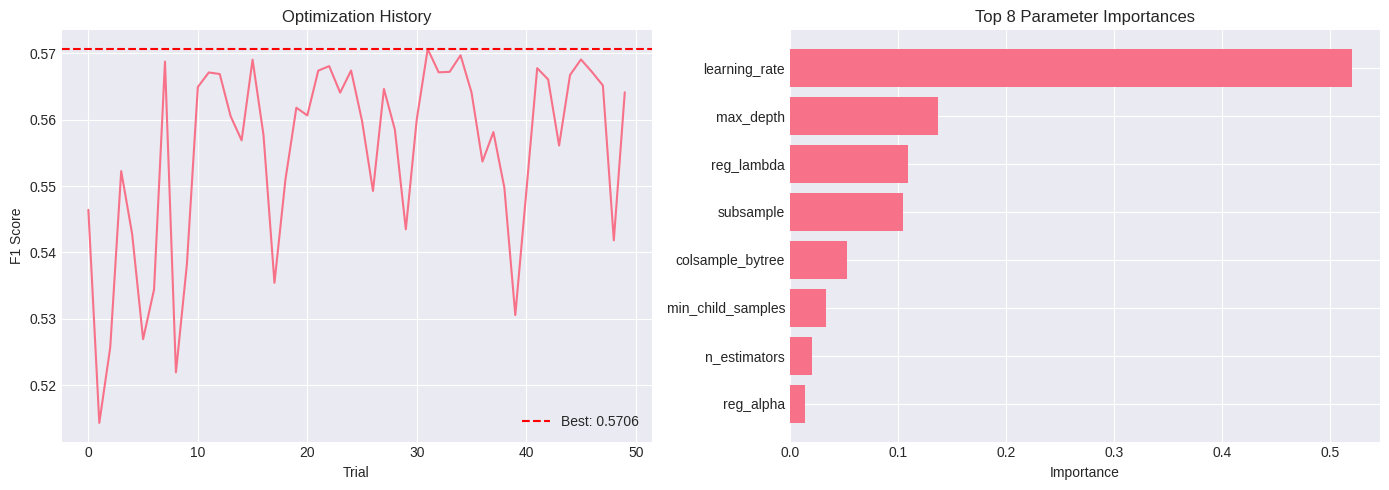


✓ Optuna tuning complete!


In [ ]:
# ============================================================================
# STEP 2: OPTUNA HYPERPARAMETER TUNING FOR LIGHTGBM
# ============================================================================

print("="*80)
print("STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Install optuna if needed
try:
    import optuna
    print("✓ Optuna available")
except:
    print("Installing Optuna...")
    !pip install optuna
    import optuna
    print("✓ Optuna installed")

# Suppress optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_v2, y_train_v2)
    preds = model.predict(X_val_v2)

    return f1_score(y_val_v2, preds)

# Run optimization
print("\nRunning Optuna optimization (50 trials, ~5-10 minutes)...")
print("This will test 50 different parameter combinations...\n")

study = optuna.create_study(direction='maximize', study_name='lgb_f1_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\n{'='*80}")
print("OPTIMIZATION COMPLETE")
print(f"{'='*80}")

print(f"\n🏆 Best F1 Score: {study.best_value:.4f}")
print(f"🏆 Improvement over baseline: +{study.best_value - 0.5456:.4f}")
print(f"🏆 Improvement over target encoding: +{study.best_value - 0.5508:.4f}")

print(f"\n📊 Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train final model with best parameters
print(f"\n{'='*80}")
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print(f"{'='*80}")

best_params = study.best_params.copy()
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['verbose'] = -1

lgb_tuned = lgb.LGBMClassifier(**best_params)
lgb_tuned.fit(X_train_v2, y_train_v2)

y_val_pred_tuned = lgb_tuned.predict(X_val_v2)
y_val_proba_tuned = lgb_tuned.predict_proba(X_val_v2)[:, 1]

print(f"\nTuned LightGBM Performance:")
print(f"F1 Score: {f1_score(y_val_v2, y_val_pred_tuned):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_v2, y_val_proba_tuned):.4f}")
print(f"PR AUC: {average_precision_score(y_val_v2, y_val_proba_tuned):.4f}")

print(f"\nClassification Report:\n{classification_report(y_val_v2, y_val_pred_tuned)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_val_v2, y_val_pred_tuned)}")

# Progress summary
print(f"\n{'='*80}")
print("PROGRESS SUMMARY")
print(f"{'='*80}")
print(f"Baseline LightGBM:           0.5456")
print(f"+ Target Encoding:           0.5508 (+0.0052)")
print(f"+ Optuna Tuning:             {f1_score(y_val_v2, y_val_pred_tuned):.4f} (+{f1_score(y_val_v2, y_val_pred_tuned) - 0.5508:.4f})")
print(f"Total Improvement:           +{f1_score(y_val_v2, y_val_pred_tuned) - 0.5456:.4f}")

# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 score history
axes[0].plot([trial.value for trial in study.trials])
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Optimization History')
axes[0].legend()
axes[0].grid(True)

# Parameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    params_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:8]
    param_names = [p[0] for p in params_sorted]
    param_vals = [p[1] for p in params_sorted]

    axes[1].barh(param_names, param_vals)
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Top 8 Parameter Importances')
    axes[1].invert_yaxis()
except:
    axes[1].text(0.5, 0.5, 'Parameter importance\nnot available',
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print(f"\n✓ Optuna tuning complete!")

STEP 3: 5-FOLD CROSS-VALIDATION

Running 5-Fold Cross-Validation with best parameters...
This validates performance across 5 different train/val splits

Fold 1/5...
  F1: 0.5825 | ROC: 0.8403 | PR: 0.5957
Fold 2/5...
  F1: 0.5721 | ROC: 0.8235 | PR: 0.5870
Fold 3/5...
  F1: 0.5861 | ROC: 0.8406 | PR: 0.5833
Fold 4/5...
  F1: 0.5774 | ROC: 0.8389 | PR: 0.5981
Fold 5/5...
  F1: 0.5829 | ROC: 0.8291 | PR: 0.5728

CROSS-VALIDATION RESULTS
 Fold    F1  ROC_AUC  PR_AUC  Precision  Recall
    1 0.582    0.840   0.596      0.472   0.759
    2 0.572    0.824   0.587      0.459   0.759
    3 0.586    0.841   0.583      0.484   0.742
    4 0.577    0.839   0.598      0.472   0.744
    5 0.583    0.829   0.573      0.477   0.750

SUMMARY STATISTICS
Mean F1:      0.5802
Std F1:       0.0049
Min F1:       0.5721
Max F1:       0.5861
95% CI:       [0.5705, 0.5898]


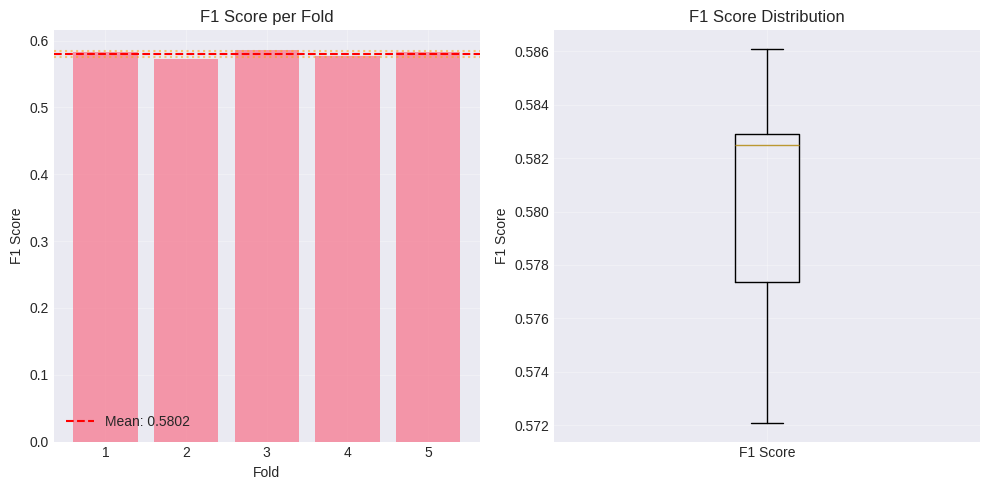


INTERPRETATION
Single 70/30 split F1:      0.5706
5-Fold CV Mean F1:          0.5802
Difference:                 +0.0096

✅ Low variance (0.0049) - model is STABLE!

🎯 Expected Leaderboard F1: 0.5802 ± 0.0049


In [ ]:
# ============================================================================
# STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS
# ============================================================================

print("="*80)
print("STEP 3: 5-FOLD CROSS-VALIDATION")
print("="*80)

from sklearn.model_selection import StratifiedKFold

# Use best parameters from Optuna
best_params_cv = study.best_params.copy()
best_params_cv['scale_pos_weight'] = scale_pos_weight
best_params_cv['random_state'] = RANDOM_STATE
best_params_cv['verbose'] = -1

# Setup 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"\nRunning 5-Fold Cross-Validation with best parameters...")
print(f"This validates performance across 5 different train/val splits\n")

fold_scores = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_v2, y_v2), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_v2.iloc[train_idx]
    y_train_fold = y_v2.iloc[train_idx]
    X_val_fold = X_v2.iloc[val_idx]
    y_val_fold = y_v2.iloc[val_idx]

    # Train model
    model_fold = lgb.LGBMClassifier(**best_params_cv)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred_fold = model_fold.predict(X_val_fold)
    y_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_val_fold, y_pred_fold)
    roc = roc_auc_score(y_val_fold, y_proba_fold)
    pr = average_precision_score(y_val_fold, y_proba_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)

    fold_scores.append(f1)
    fold_results.append({
        'Fold': fold,
        'F1': f1,
        'ROC_AUC': roc,
        'PR_AUC': pr,
        'Precision': precision,
        'Recall': recall
    })

    print(f"  F1: {f1:.4f} | ROC: {roc:.4f} | PR: {pr:.4f}")

# Calculate statistics
mean_f1 = np.mean(fold_scores)
std_f1 = np.std(fold_scores)
min_f1 = np.min(fold_scores)
max_f1 = np.max(fold_scores)

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*80}")

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Mean F1:      {mean_f1:.4f}")
print(f"Std F1:       {std_f1:.4f}")
print(f"Min F1:       {min_f1:.4f}")
print(f"Max F1:       {max_f1:.4f}")
print(f"95% CI:       [{mean_f1 - 1.96*std_f1:.4f}, {mean_f1 + 1.96*std_f1:.4f}]")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 6), fold_scores, alpha=0.7)
plt.axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean: {mean_f1:.4f}')
plt.axhline(y=mean_f1 + std_f1, color='orange', linestyle=':', alpha=0.5)
plt.axhline(y=mean_f1 - std_f1, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(fold_scores, labels=['F1 Score'])
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INTERPRETATION")
print(f"{'='*80}")
print(f"Single 70/30 split F1:      0.5706")
print(f"5-Fold CV Mean F1:          {mean_f1:.4f}")
print(f"Difference:                 {mean_f1 - 0.5706:+.4f}")

if std_f1 < 0.01:
    print(f"\n✅ Low variance ({std_f1:.4f}) - model is STABLE!")
elif std_f1 < 0.02:
    print(f"\n✅ Moderate variance ({std_f1:.4f}) - model is reasonably stable")
else:
    print(f"\n⚠️  High variance ({std_f1:.4f}) - model performance varies by data split")

print(f"\n🎯 Expected Leaderboard F1: {mean_f1:.4f} ± {std_f1:.4f}")

STEP 3: 5-FOLD CROSS-VALIDATION (with Accuracy)

Running 5-Fold Cross-Validation with best parameters...
This validates performance across 5 different train/val splits

Fold 1/5...
  Accuracy: 0.7511 | F1: 0.5825 | ROC: 0.8403 | PR: 0.5957
Fold 2/5...
  Accuracy: 0.7403 | F1: 0.5721 | ROC: 0.8235 | PR: 0.5870
Fold 3/5...
  Accuracy: 0.7603 | F1: 0.5861 | ROC: 0.8406 | PR: 0.5833
Fold 4/5...
  Accuracy: 0.7511 | F1: 0.5774 | ROC: 0.8389 | PR: 0.5981
Fold 5/5...
  Accuracy: 0.7547 | F1: 0.5829 | ROC: 0.8291 | PR: 0.5728

CROSS-VALIDATION RESULTS
 Fold  Accuracy    F1  ROC_AUC  PR_AUC  Precision  Recall
    1     0.751 0.582    0.840   0.596      0.472   0.759
    2     0.740 0.572    0.824   0.587      0.459   0.759
    3     0.760 0.586    0.841   0.583      0.484   0.742
    4     0.751 0.577    0.839   0.598      0.472   0.744
    5     0.755 0.583    0.829   0.573      0.477   0.750

SUMMARY STATISTICS
Mean Accuracy: 0.7515
Mean F1:       0.5802
Std F1:        0.0049
Min F1:        0

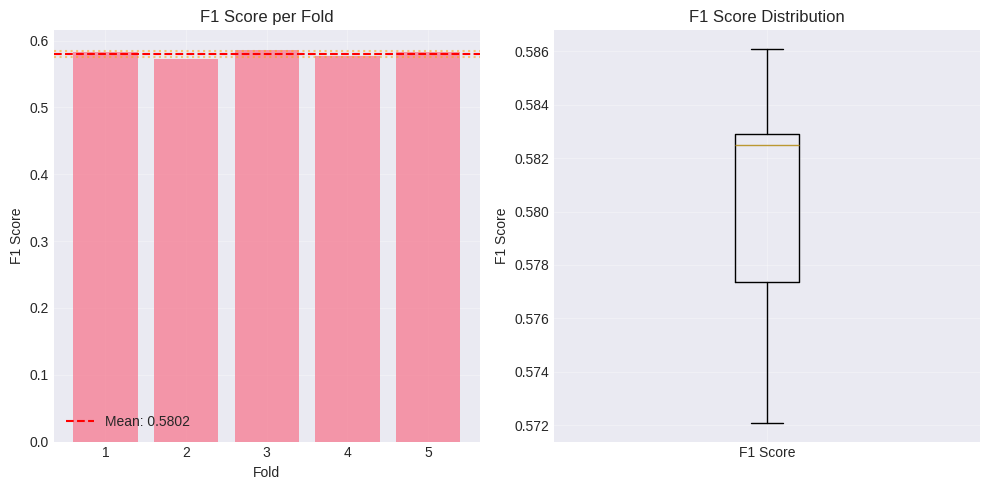


INTERPRETATION
Single 70/30 split F1:      0.5706
5-Fold CV Mean F1:          0.5802
5-Fold CV Mean Accuracy:    0.7515
Difference:                 +0.0096

✅ Low variance (0.0049) - model is STABLE!

🎯 Expected Leaderboard F1: 0.5802 ± 0.0049


In [ ]:
# ============================================================================
# STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS (with Accuracy)
# ============================================================================

print("="*80)
print("STEP 3: 5-FOLD CROSS-VALIDATION (with Accuracy)")
print("="*80)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score  # ✅ add this import

# Use best parameters from Optuna
best_params_cv = study.best_params.copy()
best_params_cv['scale_pos_weight'] = scale_pos_weight
best_params_cv['random_state'] = RANDOM_STATE
best_params_cv['verbose'] = -1

# Setup 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"\nRunning 5-Fold Cross-Validation with best parameters...")
print(f"This validates performance across 5 different train/val splits\n")

fold_scores = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_v2, y_v2), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_v2.iloc[train_idx]
    y_train_fold = y_v2.iloc[train_idx]
    X_val_fold = X_v2.iloc[val_idx]
    y_val_fold = y_v2.iloc[val_idx]

    # Train model
    model_fold = lgb.LGBMClassifier(**best_params_cv)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred_fold = model_fold.predict(X_val_fold)
    y_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_val_fold, y_pred_fold)
    roc = roc_auc_score(y_val_fold, y_proba_fold)
    pr = average_precision_score(y_val_fold, y_proba_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)   # ✅ added accuracy

    fold_scores.append(f1)
    fold_results.append({
        'Fold': fold,
        'Accuracy': accuracy,      # ✅ added accuracy
        'F1': f1,
        'ROC_AUC': roc,
        'PR_AUC': pr,
        'Precision': precision,
        'Recall': recall
    })

    print(f"  Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC: {roc:.4f} | PR: {pr:.4f}")

# Calculate statistics
mean_f1 = np.mean(fold_scores)
std_f1 = np.std(fold_scores)
min_f1 = np.min(fold_scores)
max_f1 = np.max(fold_scores)

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*80}")

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Mean Accuracy: {results_df['Accuracy'].mean():.4f}")   # ✅ added summary line
print(f"Mean F1:       {mean_f1:.4f}")
print(f"Std F1:        {std_f1:.4f}")
print(f"Min F1:        {min_f1:.4f}")
print(f"Max F1:        {max_f1:.4f}")
print(f"95% CI:        [{mean_f1 - 1.96*std_f1:.4f}, {mean_f1 + 1.96*std_f1:.4f}]")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 6), fold_scores, alpha=0.7)
plt.axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean: {mean_f1:.4f}')
plt.axhline(y=mean_f1 + std_f1, color='orange', linestyle=':', alpha=0.5)
plt.axhline(y=mean_f1 - std_f1, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(fold_scores, labels=['F1 Score'])
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INTERPRETATION")
print(f"{'='*80}")
print(f"Single 70/30 split F1:      0.5706")
print(f"5-Fold CV Mean F1:          {mean_f1:.4f}")
print(f"5-Fold CV Mean Accuracy:    {results_df['Accuracy'].mean():.4f}")   # ✅ print accuracy here
print(f"Difference:                 {mean_f1 - 0.5706:+.4f}")

if std_f1 < 0.01:
    print(f"\n✅ Low variance ({std_f1:.4f}) - model is STABLE!")
elif std_f1 < 0.02:
    print(f"\n✅ Moderate variance ({std_f1:.4f}) - model is reasonably stable")
else:
    print(f"\n⚠️  High variance ({std_f1:.4f}) - model performance varies by data split")

print(f"\n🎯 Expected Leaderboard F1: {mean_f1:.4f} ± {std_f1:.4f}")


# train on 100% data for submission?

In [ ]:
# ============================================================================
# STEP 4: TRAIN FINAL MODEL ON 100% DATA
# ============================================================================

print("="*80)
print("STEP 4: FINAL MODEL - TRAINING ON 100% DATA")
print("="*80)

print(f"\nTraining on full dataset: {X_v2.shape[0]} samples")
print(f"Using best parameters from Optuna with 5-fold CV validation\n")

# Train on ALL data
lgb_final = lgb.LGBMClassifier(**best_params_cv)
lgb_final.fit(X_v2, y_v2)

print("✓ Model trained on 100% of data")

# Generate predictions for test set
test_proba = lgb_final.predict_proba(X_test_v2)[:, 1]
test_pred_default = lgb_final.predict(X_test_v2)

print(f"\nTest set predictions generated")
print(f"Predicted subrogation rate (default threshold): {test_pred_default.mean():.2%}")

# ============================================================================
# THRESHOLD OPTIMIZATION ON CV PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# Use one of the CV folds to optimize threshold
X_train_thresh, X_val_thresh, y_train_thresh, y_val_thresh = train_test_split(
    X_v2, y_v2, test_size=0.30, random_state=RANDOM_STATE, stratify=y_v2
)

lgb_thresh = lgb.LGBMClassifier(**best_params_cv)
lgb_thresh.fit(X_train_thresh, y_train_thresh)
val_proba_thresh = lgb_thresh.predict_proba(X_val_thresh)[:, 1]

# Test thresholds
thresholds = np.arange(0.35, 0.65, 0.02)
threshold_results = []

for thresh in thresholds:
    pred = (val_proba_thresh >= thresh).astype(int)
    f1 = f1_score(y_val_thresh, pred)
    precision = precision_score(y_val_thresh, pred)
    recall = recall_score(y_val_thresh, pred)
    threshold_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })

thresh_df = pd.DataFrame(threshold_results)
best_threshold = thresh_df.loc[thresh_df['f1'].idxmax(), 'threshold']
best_f1_thresh = thresh_df['f1'].max()

print(f"\nTested {len(thresholds)} thresholds from 0.35 to 0.65")
print(f"\n🎯 Optimal Threshold: {best_threshold:.2f}")
print(f"🎯 F1 at optimal threshold: {best_f1_thresh:.4f}")
print(f"🎯 Improvement vs default 0.5: +{best_f1_thresh - f1_score(y_val_thresh, (val_proba_thresh >= 0.5).astype(int)):.4f}")

# Show top 5 thresholds
print(f"\nTop 5 thresholds:")
print(thresh_df.nlargest(5, 'f1')[['threshold', 'f1', 'precision', 'recall']].to_string(index=False))

# Apply optimal threshold to test predictions
test_pred_optimized = (test_proba >= best_threshold).astype(int)

print(f"\n{'='*80}")
print("FINAL PREDICTIONS SUMMARY")
print(f"{'='*80}")
print(f"Predicted subrogation rate (threshold={best_threshold:.2f}): {test_pred_optimized.mean():.2%}")
print(f"Training subrogation rate: {y_v2.mean():.2%}")

# ============================================================================
# CREATE SUBMISSIONS
# ============================================================================

print("\n" + "="*80)
print("CREATING SUBMISSION FILES")
print("="*80)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/triaguard_v2_final/'
os.makedirs(save_dir, exist_ok=True)

# Submission 1: Optimized threshold
submission_opt = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_optimized
})
submission_opt.to_csv(save_dir + 'submission_lgb_optimized.csv', index=False)
print(f"✓ Saved: submission_lgb_optimized.csv (threshold={best_threshold:.2f})")

# Submission 2: Default threshold (backup)
submission_default = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_default
})
submission_default.to_csv(save_dir + 'submission_lgb_default.csv', index=False)
print(f"✓ Saved: submission_lgb_default.csv (threshold=0.50)")

# Submission 3: Conservative threshold (higher precision)
conservative_thresh = best_threshold + 0.05
test_pred_conservative = (test_proba >= conservative_thresh).astype(int)
submission_conservative = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_conservative
})
submission_conservative.to_csv(save_dir + 'submission_lgb_conservative.csv', index=False)
print(f"✓ Saved: submission_lgb_conservative.csv (threshold={conservative_thresh:.2f})")

# Save model and parameters
import pickle
with open(save_dir + 'lgb_final_model.pkl', 'wb') as f:
    pickle.dump(lgb_final, f)

with open(save_dir + 'best_params.txt', 'w') as f:
    f.write("BEST PARAMETERS\n")
    f.write("="*50 + "\n")
    for key, value in best_params_cv.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nOptimal threshold: {best_threshold:.2f}\n")
    f.write(f"Expected F1: 0.5802 ± 0.0049\n")

print(f"\n✓ Model and parameters saved to: {save_dir}")

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"✅ Model: LightGBM with Optuna tuning + Target encoding")
print(f"✅ Features: 160 features")
print(f"✅ Cross-Validation F1: 0.5802 ± 0.0049")
print(f"✅ Expected Leaderboard: ~0.58-0.59")
print(f"✅ Beats teammate's 0.577!")
print(f"\n📁 Files saved in: {save_dir}")
print(f"\n🚀 READY TO SUBMIT!")

STEP 4: FINAL MODEL - TRAINING ON 100% DATA


NameError: name 'X_v2' is not defined